In [1]:
 """
 This is an instructional Jupyter notebook for analyzing price
 changes during the business hours of other markets. To roughly
 estimate which regions are buying/selling more than others.
 
 Author: T. From Coding Always & Data Always. 
 Twitter: @Data_Always
 
 Last Modified: Feb 16, 2022
 """

'\nThis is an instructional Jupyter notebook for analyzing price\nchanges during the business hours of other markets. To roughly\nestimate which regions are buying/selling more than others.\n\nAuthor: T. From Coding Always & Data Always. \nTwitter: @Data_Always\n\nLast Modified: Feb 16, 2022\n'

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
# Import some common libraries

warnings.filterwarnings('ignore')
# The tick-label formatting I do likes to throw warnings.

def set_plt_defaults():
    plt.rcParams['figure.figsize'] = (14, 10)
    # Default figure size.

    plt.rcParams['figure.subplot.left'] = 0.10
    plt.rcParams['figure.subplot.top'] = 0.92
    plt.rcParams['figure.subplot.right'] = 0.90
    # Position the chart in the figure
        
    fig_out = plt.figure()
    ax_out = plt.subplot2grid((1,1), (0,0))
    # Assign the outputs to return.
    
    ax_out.yaxis.set_ticks_position('none')
    # No tick dashes at the left-boundary of the grid
        
    plt.grid(color=[0.25]*3, 
             linestyle='-', 
             linewidth=0.75, 
             alpha=0.25, 
             zorder=0
            )
    # Gridline styling
    
    ax_out.xaxis.grid()
    # Only plot horizontal gridlines.

    ax_out.axhline(linewidth=1, color='black')
    # Plot the x-axis zero-line
        
    plt.box(False)
    # Box around the figure. 
    
    return fig_out, ax_out;


In [3]:
data = pd.read_csv("gemini_BTCUSD_1hr.csv", skiprows=2)  
# Read in the data while skipping the non-formatted cells

df_btc = pd.DataFrame(data)
# Convert the data to a dataframe for better management/analysis

df_btc.columns = ['timestamp', 
                  'date',
                  'symbol',
                  'open',
                  'high',
                  'low',
                  'close',
                  'volume'
                 ]
# Rename all the columns to our preferences

df_btc = df_btc.sort_values(by="date")
# Make sure all the data is sorted appropriately

df_btc = df_btc.set_index(pd.DatetimeIndex(df_btc['date']))
# Make the main index of the data the date

In [4]:
df_btc['short-date'] = [pd.to_datetime(val).date() for val in df_btc['date']]
# Extract the day from the date string (which includes times)

df_btc['hour'] = [pd.to_datetime(val).time().hour for val in df_btc['date']]
# Extract the hour from the date string (which includes times)

print("Finished extracting dates and time from raw data.")
# Display an update for the user

df_btc['hk-open'] = df_btc['hour'].apply(lambda x: 1 if (x+8) % 24 >= 8 and (x+8) % 24 < 18 else 0)
# If it's between 8am and 6pm in hong kong, label it as open

df_btc['nyc-open'] = df_btc['hour'].apply(lambda x: 1 if (x-5) % 24 >= 8 and (x-5) % 24 < 18 else 0)
# If it's between 8am and 6pm in nyc, label it as open

print("Finished extracting HK/NYC open-status from data.")
# Display an update for the user

df_btc['hk-change'] = df_btc['close'].diff() * df_btc['hk-open']
df_btc['nyc-change'] = df_btc['close'].diff() * df_btc['nyc-open']
# Now take the product of the open/closed status and price changes

print("Finished calculating price changes during HK/NYC workday.")

Finished extracting dates and time from raw data.
Finished extracting HK/NYC open-status from data.
Finished calculating price changes during HK/NYC workday.


In [5]:
resample_dict = {
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last',
    'volume':'sum',
    'hk-change':'sum',
    'nyc-change':'sum',
    'short-date':'first'
}
# Define how we want to resample the data from hourly to daily

df_btc = df_btc.resample("1D").agg(resample_dict)
# Resample the data

df_btc = df_btc.rename(columns={"short-date": "date"})
# Rename the date column

df_btc['date'] = pd.to_datetime(df_btc['date'])
# Convert the dates from strings to datetime objects

In [6]:
df_btc.tail()
# Display the last few days of data

,open,high,low,close,volume,hk-change,nyc-change,date
date,,,,,,,,
2022-02-12,42396.78,43046.93,41772.56,42241.96,370.723107,24.03,-93.62,2022-02-12
2022-02-13,42241.96,42762.14,41889.00,42079.70,378.983118,104.41,-101.20,2022-02-13
2022-02-14,42079.70,42853.19,41582.85,42548.46,1004.293146,-9.12,145.51,2022-02-14
2022-02-15,42548.46,44772.80,42458.39,44564.44,1086.041188,1514.33,-7.55,2022-02-15
2022-02-16,44564.44,44564.44,43940.94,44014.68,75.719914,-549.76,0.00,2022-02-16


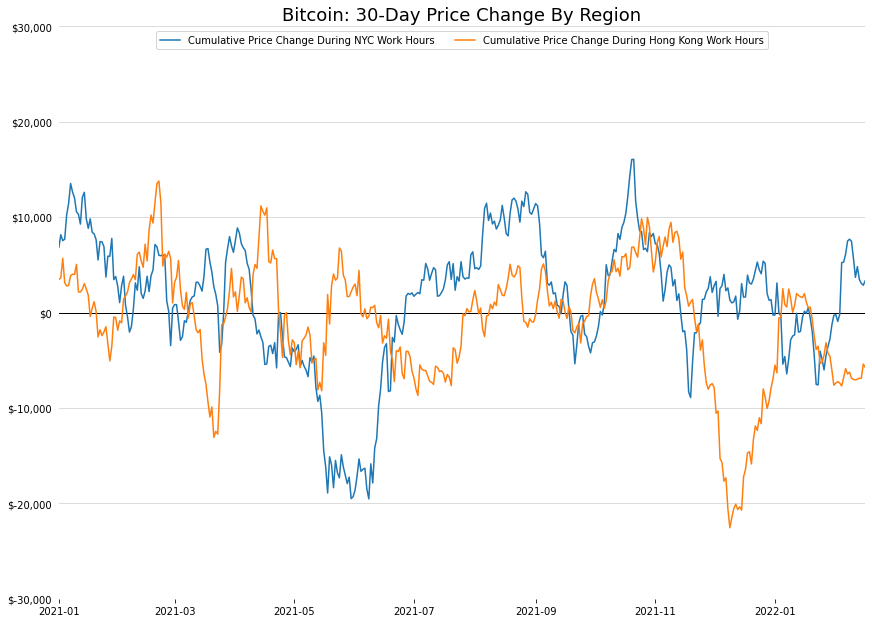

In [7]:
""" 
The first chart we're going to make is just a simple pair of 
line plots with the 30-day rolling sum of the changes during
HK and NYC business hours.
"""

ws = 30
# The window size for the data that we window size we are summing over

start_date = '2020-12-01'
tmp_df = df_btc[df_btc['date'] > pd.to_datetime(start_date)]
# Create a duplicate dataframe with data restricted to after a start_date

fig, ax1 = set_plt_defaults()
# Create a figure with our standard design parameters

plt.title(f'Bitcoin: {ws}-Day Price Change By Region', size=18)
# Dynamic title with the text changing for the window size

ax1.plot(tmp_df['date'], 
         tmp_df['nyc-change'].rolling(ws).sum(), 
         label='Cumulative Price Change During NYC Work Hours'
        )
# Plot the New York City data

ax1.plot(tmp_df['date'], 
         tmp_df['hk-change'].rolling(ws).sum(),
         label='Cumulative Price Change During Hong Kong Work Hours'
        )
# Plot the Hong Kong data

ax1.set_xlim(tmp_df['date'][ws], tmp_df['date'][-1])
# Set the horizontal boundary of the figure tight to the data.

ax1.set_ylim([-30000, 30000])
# Equalize the vertical axis

ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])
# Change the yticklabels to a proper financial format

plt.legend(loc='upper center', ncol=2)
# Create a simple side-by-side legend

plt.savefig('./price-change-by-region.png', transparent=False, facecolor='white')
# Save the figure

plt.show()
# Display the figure. Not necessary in Jupyter.

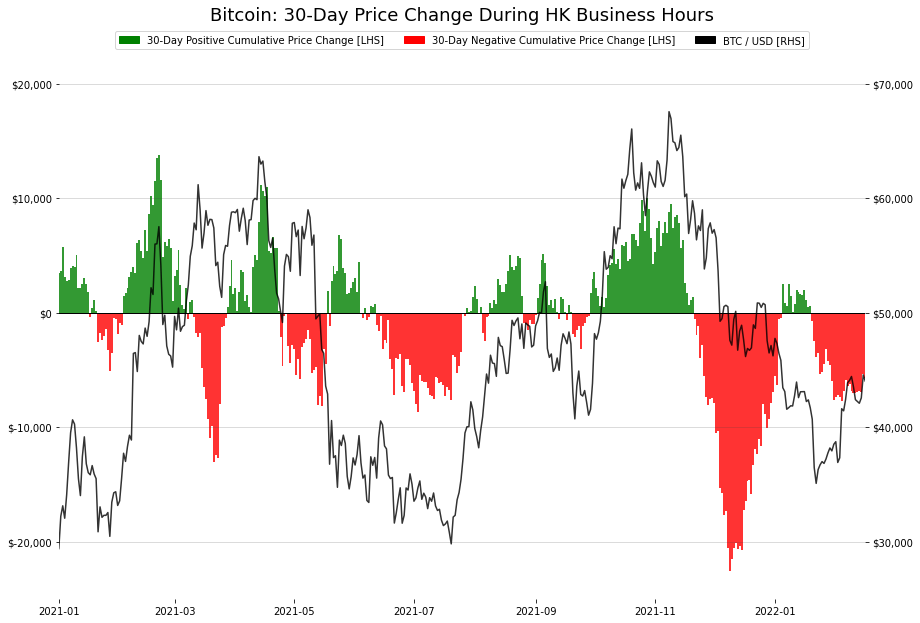

In [8]:
""" 
Next up, we're going to zoom in on only the Hong Kong data and make
a bar chart that is colored green/red depending on whether the 
rolling sum is positive or negative. We're also going to plot the
price of bitcoin alongside it.
"""

ws = 30
# The window size for the data that we window size we are summing over

start_date = '2020-12-01'
tmp_df = df_btc[df_btc['date'] > pd.to_datetime(start_date)]
# Create a duplicate dataframe with data restricted to after a start_date

fig, ax1 = set_plt_defaults()
# Create a figure with our standard design parameters

plt.title(f'Bitcoin: {ws}-Day Price Change During HK Business Hours', size=18)
# Dynamic title with the text changing for the window size

ax1.bar(tmp_df['date'], 
        tmp_df['hk-change'].rolling(ws).sum(), 
        width=1.0, 
        alpha=0.8,
        color=['r' if (x < 0) else 'g' for x in tmp_df['hk-change'].rolling(ws).sum()]
        # Color the bar red if negative, and green if positive
       )
# Create a bar-plot of the change data with custom coloring.

ax1.set_xlim(tmp_df['date'][ws], tmp_df['date'][-1])
# Set the horizontal boundary of the figure tight to the data.

ax1.set_ylim([-25000, 25000])
# Equalize the LHS vertical axis

ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])
# Change the LHS yticklabels to a proper financial format

ax2 = ax1.twinx()
# Create a twin of the x-axis so that we can plot another price alongside

ax2.plot(tmp_df['date'], 
         tmp_df['close'], 
         color='k', 
         alpha=0.8
        )
# Plot the price alongside the bar plot

ax2.set_ylim([25000, 75000])
# Set the ylimits for the RHS data

ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
# Change the RHS yticklabels to a proper financial format

green_patch = mpatches.Patch(color='g', label=f'{ws}-Day Positive Cumulative Price Change [LHS]')
red_patch = mpatches.Patch(color='r', label=f'{ws}-Day Negative Cumulative Price Change [LHS]')
black_patch = mpatches.Patch(color='k', label='BTC / USD [RHS]')
# Create custom labels for the legend

ax1.legend(handles=[green_patch, red_patch, black_patch], loc='upper center', ncol=3)
# Add a legend to the plot

plt.box(False)
# We need to remove the box around the figure again if we twin the x-axis

plt.savefig('./price-change-hong-kong.png', transparent=False, facecolor='white')
# Save the figure

plt.show()
# Display the figure. Not necessary in Jupyter.

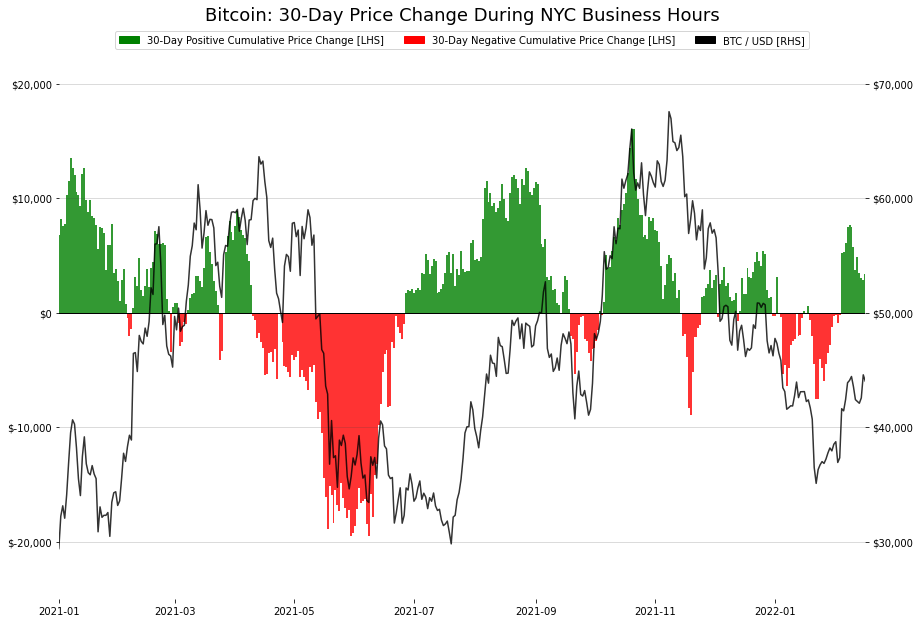

In [9]:
# Duplicate of the Hong Kong code but swapping it for New York

ws = 30
# The window size for the data that we window size we are summing over

start_date = '2020-12-01'
tmp_df = df_btc[df_btc['date'] > pd.to_datetime(start_date)]
# Create a duplicate dataframe with data restricted to after a start_date

fig, ax1 = set_plt_defaults()
# Create a figure with our standard design parameters

plt.title(f'Bitcoin: {ws}-Day Price Change During NYC Business Hours', size=18)
# Dynamic title with the text changing for the window size

ax1.bar(tmp_df['date'], 
        tmp_df['nyc-change'].rolling(ws).sum(), 
        width=1.0, 
        alpha=0.8,
        color=['r' if (x < 0) else 'g' for x in tmp_df['nyc-change'].rolling(ws).sum()]
        # Color the bar red if negative, and green if positive
       )
# Create a bar-plot of the change data with custom coloring.

ax1.set_xlim(tmp_df['date'][ws], tmp_df['date'][-1])
# Set the horizontal boundary of the figure tight to the data.

ax1.set_ylim([-25000, 25000])
# Equalize the LHS vertical axis

ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])
# Change the LHS yticklabels to a proper financial format

ax2 = ax1.twinx()
# Create a twin of the x-axis so that we can plot another price alongside

ax2.plot(tmp_df['date'], 
         tmp_df['close'], 
         color='k', 
         alpha=0.8
        )
# Plot the price alongside the bar plot

ax2.set_ylim([25000, 75000])
# Set the ylimits for the RHS data

ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
# Change the RHS yticklabels to a proper financial format

green_patch = mpatches.Patch(color='g', label=f'{ws}-Day Positive Cumulative Price Change [LHS]')
red_patch = mpatches.Patch(color='r', label=f'{ws}-Day Negative Cumulative Price Change [LHS]')
black_patch = mpatches.Patch(color='k', label='BTC / USD [RHS]')
# Create custom labels for the legend

ax1.legend(handles=[green_patch, red_patch, black_patch], loc='upper center', ncol=3)
# Add a legend to the plot

plt.box(False)
# We need to remove the box around the figure again if we twin the x-axis

plt.savefig('./price-change-new-york.png', transparent=False, facecolor='white')
# Save the figure

plt.show()
# Display the figure. Not necessary in Jupyter.

In [10]:
# Code to look at the the 2017 bubble instead of modern data.
start_date = '2017-06-01'
end_date = '2018-07-01'
tmp_df = df_btc[df_btc['date'] > pd.to_datetime(start_date)]
tmp_df = tmp_df[tmp_df['date'] <= pd.to_datetime(end_date)]